#Author: Hyunwoo Choi
#Mail: herochw@gmail.com


In [77]:
import torch
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.distributions import multivariate_normal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis

import random

# Load MNIST data

In [78]:
train_data = np.loadtxt('/content/train.txt')
train_vec = train_data[:,:-1]
train_lab = train_data[:,-1]

train_x = torch.tensor(train_vec)
train_y = torch.tensor(train_lab)

val_data = np.loadtxt('/content/validate.txt')
val_vec = val_data[:,:-1]
val_lab = val_data[:,-1]

val_x = torch.tensor(val_vec)
val_y = torch.tensor(val_lab)

test_data = np.loadtxt('/content/test.txt')
test_vac = test_data[:,:-1]
test_lab = test_data[:,-1]

#Sample and view dataset

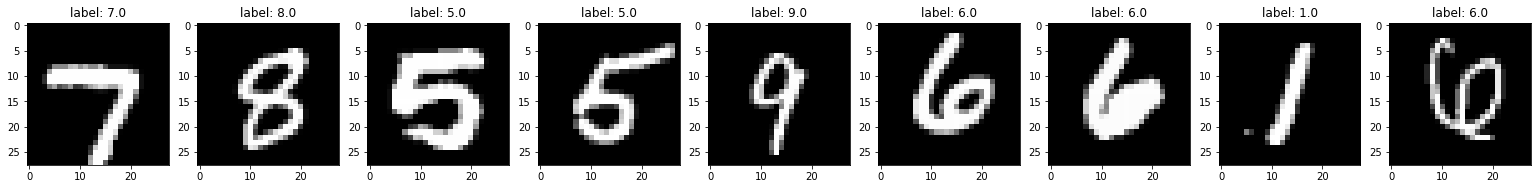

In [79]:
fig  = figure(figsize=(30,15))
for i in range(1,10):
  a = fig.add_subplot(1,10,i)
  j = random.randint(0,2000)
  image = train_x[j].view(-1,28,28).T
  label = train_y[j]
  imshow(np.squeeze(image),cmap='gray')
  a.set_title('label: {}'.format(label))
  #axis('off')
  

#Generate feature 
 Output: Number of non-zero pixels on each row & each col (none,56)

In [80]:
def feature(X, threshold=0):

  x_row = (X > threshold).reshape(-1,28,28).sum(dim=1)
  x_col = (X > threshold).reshape(-1,28,28).sum(dim=2)
  return torch.cat([x_row,x_col],dim=1).double()

#Training the Multivariate Normal 

---


>Fit a Gaussian to data points $x^{(1)}, x^{(2)}, x^{(3)}, ... , x^{(n)} \in \mathbb{R}^{d}$

>$ mean = \frac{1}{\mu} (x^{(1)} + x^{(2)} + x^{(3)} +  ... + x^{(n)}) $

>Covariance Matrix $\sum_{ij} =  \frac{1}{m} \sum_{k=1}^{n} (x_{i}^{k} - \mu^{i})(x_{j}^{k} - \mu^{j})$

>More Compact Notation: $\sum =  \frac{1}{m} \sum_{k=1}^{n} (x_{i}^{k} - \mu^{i})(x_{j}^{k} - \mu^{j})^{T} + C \cdot I_{d}$ where C is a small positive int


In [76]:
dists = []
c = 5 # constant
for index in range(0,10,1):
  mask = torch.eq(train_y,index)
  x_by_label = train_x[mask]

  X = feature(x_by_label)
  
  x_mean = torch.mean(X,dim = 0)
  x_var = torch.var(X, dim = 0)
  x_cov = torch.from_numpy(np.cov(X, rowvar=False)) + torch.eye(56) * c

  gaussian_dist = torch.distributions.multivariate_normal.MultivariateNormal(x_mean,x_cov)
  dists.append(gaussian_dist)

#Evaluate the data

---
>Multiclass Discriminative Analysis

>$k$ Classes, $\pi_{j}$ weights, Class conditional density $P_j = N(\mu,\sum)$

> The quadratic function $f_j(x) = \log(\pi_j \cdot p_j(x))$

> To classify the point $x$, pick  arg$max_{j} f_{j}(x)$

In [74]:
num_classes = 10 # {0,1,2, ... 9}
weight = torch.tensor([0.1])
correct = 0
wrong = []

for i in range(val_x.shape[0]):
  X = val_x[i]
  Y = val_y[i]
  pre_X = feature(torch.reshape(X,(1,-1)))
  result = [dists[j].log_prob(pre_X) + torch.log(weight) for j in range(num_classes)]
  prediction = torch.argmax(torch.tensor(result))
  if prediction == Y.long():
    correct += 1
  else:
    wrong.append([X,prediction])
print("The accuracy is {:.3f}".format(correct/ val_x.shape[0]))

The accuracy is 0.807


#Wrongly predicted images

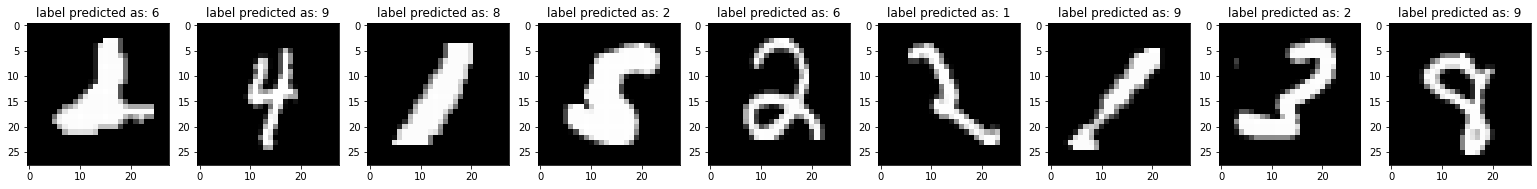

In [61]:
fig  = figure(figsize=(30,15))
for i in range(1,10):
  a = fig.add_subplot(1,10,i)
  sample = random.choice(wrong)
  image = sample[0].view(-1,28,28).T
  label = sample[1]
  imshow(np.squeeze(image),cmap='gray')
  a.set_title('label predicted as: {}'.format(label))
  #axis('off')